In [20]:
import statistics as s
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from numpy.polynomial.polynomial import polyfit
from sklearn.preprocessing import PolynomialFeatures
from sklearn.feature_selection import VarianceThreshold, SelectKBest, chi2, SelectFromModel, RFE, RFECV
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
import statsmodels.api as sm
from mlxtend.feature_selection import SequentialFeatureSelector as sfs
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
from sklearn.metrics import mean_squared_error, mean_squared_log_error, max_error, r2_score, mean_absolute_error
from sklearn.model_selection import train_test_split, cross_val_score, KFold, validation_curve, GridSearchCV, cross_val_predict
from sklearn.cross_decomposition import PLSRegression
from sklearn.decomposition import PCA
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasRegressor
from keras.metrics import MeanSquaredError
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.neural_network import MLPRegressor
from sklearn import svm
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.pipeline import make_pipeline
from math import sqrt, log, log10
from scipy.stats import shapiro
%matplotlib inline 
plt.rcParams['figure.figsize'] = (12, 8)

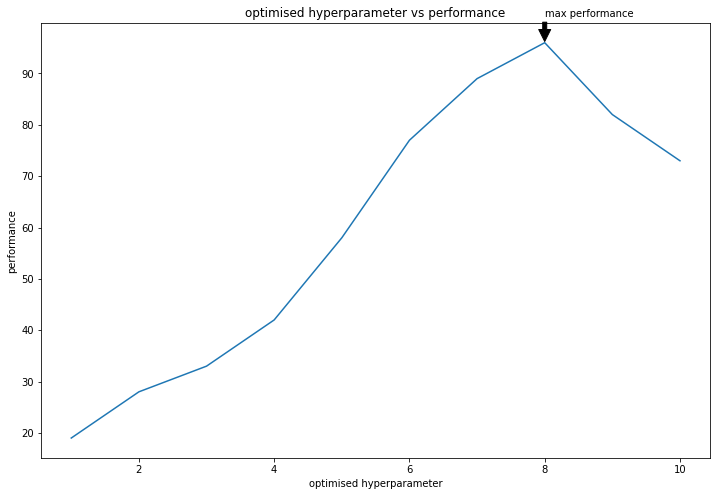

In [ ]:
opt=np.linspace(1,10,10)
per=[19,28,33,42,58,77,89,96,82,73]
ymax = max(per)
xpos = per.index(ymax)
xmax = opt[xpos]
fig = plt.figure()
ax = fig.add_subplot(111)
line, = ax.plot(opt,per)
ax.annotate('max performance', xy=(xmax, ymax), xytext=(xmax, ymax+5),arrowprops=dict(facecolor='black', shrink=0.05),)
plt.title("optimised hyperparameter vs performance")
plt.xlabel("optimised hyperparameter")
plt.ylabel("performance")
plt.show()

In [30]:
DBCT_PT=pd.read_csv("https://bit.ly/DBNTpt",index_col=0,decimal = ',')#,sep=";"
l=DBCT_PT.shape[0]
c=DBCT_PT.shape[1]
Y=DBCT_PT["Y"]
X=DBCT_PT.drop("Y",axis=1)

In [31]:
testR2=[]
testRMSE=[]
trainR2=[]
trainRMSE=[]
CVR2=[]
CVRMSE=[]
aic=[]
bic=[]
rpd=[]

In [32]:
def R2(model,x,y,methode):
  pr=pd.Series(model.predict(x))
  err=pr-y
  pr.index=range(len(pr))
  y.index=range(len(y))
  ssr=[]
  sse=[]
  sst=[]
  for i in pr:
    ssr.append((i-s.mean(y))**2)
  for j in y:
    sst.append((j-s.mean(y))**2)
  for k,l in zip(y,pr):
    sse.append((k-l)**2)
  if(methode=="model"):
    return sum(ssr)/sum(sst)
  elif(methode=="residual"):
    return 1-(sum(sse)/sum(sst))
def MSE(y,ypr):
  ss=[]
  for i,j in zip(y,ypr):
    ss.append((i-j)**2)
  return ((1/len(y))*sum(ss))[0]
def AIC(model,y,ypr,n):
    cal_aic = len(y) * log(MSE(y,ypr)) + 2 * (n + 1)
    return cal_aic
def BIC(model,y,ypr,n):
  cal_bic = len(y) * log(MSE(y,ypr)) + (n + 1) * log(len(y))
  return cal_bic
def adj_r2(model,x,y):
  r2=model.score(x,y)
  n=x.shape[0]
  p=x.shape[1]
  return 1-((1-r2)*(n-1)/(n-p-1))
def RPD(x,y,model):
  return x.std().mean()/sqrt(mean_squared_error(y,model.predict(x)))

In [33]:
x_train, x_test, y_train, y_test = train_test_split(X,Y,test_size=0.2,random_state = 0)

In [34]:
pls=PLSRegression(n_components=29)
pls.fit(x_train, y_train)
"""
print("Test : ")
print("AIC : ",AIC(pls,y_test,pls.predict(x_test)))
print("BIC : ",BIC(pls,y_test,pls.predict(x_test)))
print("R-squared:", pls.score(x_test,y_test)*100, "%")
print("RMSE:", sqrt(mean_squared_error(y_test, pls.predict(x_test))))
print("Max-E:", max_error(y_test, pls.predict(x_test)))
print("Train : ")
print("AIC : ",AIC(pls,y_train,pls.predict(x_train)))
print("BIC : ",BIC(pls,y_train,pls.predict(x_train)))
print("R-squared : ", pls.score(x_train,y_train)*100, "%")
print("RMSE:", sqrt(mean_squared_error(y_train, pls.predict(x_train))))
print("Max-E:", max_error(y_train, pls.predict(x_train)))
print("CV : ")
cv_RMSE_scores=cross_val_score(PLSRegression(n_components=24), x_train, y_train, scoring='neg_root_mean_squared_error', cv=5)
print("RMSE : ",abs(np.mean(cv_RMSE_scores)))
cv_Rsquared_scores=cross_val_score(PLSRegression(n_components=24), x_train, y_train, scoring='r2', cv=5)
print("R-squared : ",np.mean(cv_Rsquared_scores)*100,"%")
"""
testR2.append(pls.score(x_test,y_test)*100)
testRMSE.append(sqrt(mean_squared_error(y_test, pls.predict(x_test))))
trainR2.append(pls.score(x_train,y_train)*100)
trainRMSE.append(sqrt(mean_squared_error(y_train, pls.predict(x_train))))
CVR2.append(np.mean(cross_val_score(PLSRegression(n_components=24), x_train, y_train, scoring='neg_root_mean_squared_error', cv=5)))
CVRMSE.append(np.mean(cross_val_score(PLSRegression(n_components=24), x_train, y_train, scoring='neg_root_mean_squared_error', cv=5)))
#aic.append(AIC(pls,y_test,pls.predict(x_test),29))
#bic.append(BIC(pls,y_test,pls.predict(x_test),29))
rpd.append(RPD(x_test,y_test,pls))
#"""

In [35]:
pcr=make_pipeline(StandardScaler(), PCA(n_components=29), LinearRegression())
pcr.fit(x_train, y_train)
"""
print("Test : ")
#print("AIC : ",AIC(pcr,y_test,pcr.predict(x_test)))
#print("BIC : ",BIC(pcr,y_test,pcr.predict(x_test)))
print("R-squared:", pcr.score(x_test,y_test)*100, "%")
print("RMSE:", sqrt(mean_squared_error(y_test, pcr.predict(x_test))))
print("Max-E:", max_error(y_test, pcr.predict(x_test)))
print("Train : ")
#print("AIC : ",AIC(pcr,y_train,pcr.predict(x_train)))
#print("BIC : ",BIC(pcr,y_train,pcr.predict(x_train)))
print("R-squared:", pcr.score(x_train,y_train)*100, "%")
print("RMSE:", sqrt(mean_squared_error(y_train, pcr.predict(x_train))))
print("Max-E:", max_error(y_train, pcr.predict(x_train)))
print("CV : ")
cv_RMSE_scores=cross_val_score(make_pipeline(StandardScaler(), PCA(n_components=29), LinearRegression()), x_train, y_train, scoring='neg_root_mean_squared_error', cv=5)
print("RMSE : ",abs(np.mean(cv_RMSE_scores)))
cv_Rsquared_scores=cross_val_score(make_pipeline(StandardScaler(), PCA(n_components=29), LinearRegression()), x_train, y_train, scoring='r2', cv=5)
print("R-squared : ",np.mean(cv_Rsquared_scores)*100,"%")
"""
testR2.append(pcr.score(x_test,y_test)*100)
testRMSE.append(sqrt(mean_squared_error(y_test, pcr.predict(x_test))))
trainR2.append(pcr.score(x_train,y_train)*100)
trainRMSE.append(sqrt(mean_squared_error(y_train, pcr.predict(x_train))))
CVR2.append(100*np.mean(cross_val_score(make_pipeline(StandardScaler(), PCA(n_components=29), LinearRegression()), x_train, y_train, scoring='r2', cv=5)))
CVRMSE.append(abs(np.mean(cross_val_score(make_pipeline(StandardScaler(), PCA(n_components=29), LinearRegression()), x_train, y_train, scoring='neg_root_mean_squared_error', cv=5))))
#aic.append(AIC(pcr,y_test,pcr.predict(x_test),29))
#bic.append(BIC(pcr,y_test,pcr.predict(x_test),29))
rpd.append(RPD(x_test,y_test,pcr))
#"""

In [36]:
svr = svm.SVR(kernel='poly', degree=8, gamma='scale', coef0=1.5, tol=0.005, C=1.0, epsilon=0.0001)
svr.fit(x_train,y_train)
"""
print("Test : ")
print("R-squared:", svr.score(x_test,y_test)*100, "%")
print("RMSE:", sqrt(mean_squared_error(y_test, svr.predict(x_test))))
print("Max-E:", max_error(y_test, svr.predict(x_test)))
print("Train : ")
print("R-squared:", svr.score(x_train,y_train)*100, "%")
print("RMSE:", sqrt(mean_squared_error(y_train, svr.predict(x_train))))
print("Max-E:", max_error(y_train, svr.predict(x_train)))
print("CV : ")
cv_RMSE_scores=cross_val_score(svm.SVR(kernel='poly', degree=8, gamma='scale', coef0=1.5, tol=0.005, C=1.0, epsilon=0.0001), x_train, y_train, scoring='neg_root_mean_squared_error', cv=5)
print("RMSE : ",abs(np.mean(cv_RMSE_scores)))
cv_Rsquared_scores=cross_val_score(svm.SVR(kernel='poly', degree=8, gamma='scale', coef0=1.5, tol=0.005, C=1.0, epsilon=0.0001), x_train, y_train, scoring='r2', cv=5)
print("R-squared : ",np.mean(cv_Rsquared_scores)*100,"%")
"""
testR2.append(svr.score(x_test,y_test)*100)
testRMSE.append(sqrt(mean_squared_error(y_test, svr.predict(x_test))))
trainR2.append(svr.score(x_train,y_train)*100)
trainRMSE.append(sqrt(mean_squared_error(y_train, svr.predict(x_train))))
CVR2.append(100*np.mean(cross_val_score(svm.SVR(kernel='linear', degree=8, gamma='scale', coef0=1.5, tol=0.005, C=1.0, epsilon=0.0001), x_train, y_train, scoring='r2', cv=5)))
CVRMSE.append(abs(np.mean(cross_val_score(svm.SVR(kernel='linear', degree=8, gamma='scale', coef0=1.5, tol=0.005, C=1.0, epsilon=0.0001), x_train, y_train, scoring='neg_root_mean_squared_error', cv=5))))
#aic.append(AIC(svr,y_test,svr.predict(x_test),8))
#bic.append(BIC(svr,y_test,svr.predict(x_test),8))
rpd.append(RPD(x_test,y_test,pcr))
#"""

In [37]:
rf=RandomForestRegressor(n_estimators=900, random_state=0, criterion='mse',min_samples_split=2, min_samples_leaf=1,n_jobs=8)
rf.fit(x_train,y_train)
"""
print("Test : ")
print("R-squared:", rf.score(x_test,y_test)*100, "%")
print("RMSE:", sqrt(mean_squared_error(y_test, rf.predict(x_test))))
print("Max-E:", max_error(y_test, rf.predict(x_test)))
print("Train : ")
print("R-squared:", rf.score(x_train,y_train)*100, "%")
print("RMSE:", sqrt(mean_squared_error(y_train, rf.predict(x_train))))
print("Max-E:", max_error(y_train, rf.predict(x_train)))
print("CV : ")
cv_RMSE_scores=cross_val_score(RandomForestRegressor(n_estimators=900, random_state=0, criterion='mse',min_samples_split=2, min_samples_leaf=1), x_train, y_train, scoring='neg_root_mean_squared_error', cv=5)
print("RMSE : ",abs(np.mean(cv_RMSE_scores)))
cv_Rsquared_scores=cross_val_score(RandomForestRegressor(n_estimators=900, random_state=0, criterion='mse',min_samples_split=2, min_samples_leaf=1), x_train, y_train, scoring='r2', cv=5)
print("R-squared : ",np.mean(cv_Rsquared_scores)*100,"%")
"""
testR2.append(rf.score(x_test,y_test)*100)
testRMSE.append(sqrt(mean_squared_error(y_test, rf.predict(x_test))))
trainR2.append(rf.score(x_train,y_train)*100)
trainRMSE.append(sqrt(mean_squared_error(y_train, rf.predict(x_train))))
CVR2.append(100*np.mean(cross_val_score(RandomForestRegressor(n_estimators=900, random_state=0, criterion='mse',min_samples_split=2, min_samples_leaf=1,n_jobs=8), x_train, y_train, scoring='r2', cv=5)))
CVRMSE.append(abs(np.mean(cross_val_score(RandomForestRegressor(n_estimators=900, random_state=0, criterion='mse',min_samples_split=2, min_samples_leaf=1,n_jobs=8), x_train, y_train, scoring='neg_root_mean_squared_error', cv=5))))
#aic.append(AIC(rf,y_test,rf.predict(x_test),1))
#bic.append(BIC(rf,y_test,rf.predict(x_test),1))
rpd.append(RPD(x_test,y_test,rf))
#"""

In [38]:
dt=DecisionTreeRegressor(random_state=0,max_leaf_nodes=11)
dt.fit(x_train,y_train)
"""
print("Test : ")
print("R-squared:", dt.score(x_test,y_test)*100, "%")
print("RMSE:", sqrt(mean_squared_error(y_test, dt.predict(x_test))))
print("Max-E:", max_error(y_test, dt.predict(x_test)))
print("Train : ")
print("R-squared:", rf.score(x_train,y_train)*100, "%")
print("RMSE:", sqrt(mean_squared_error(y_train, dt.predict(x_train))))
print("Max-E:", max_error(y_train, dt.predict(x_train)))
print("CV : ")
cv_RMSE_scores=cross_val_score(DecisionTreeRegressor(random_state=0,max_leaf_nodes=11), x_train, y_train, scoring='neg_root_mean_squared_error', cv=5)
print("RMSE : ",abs(np.mean(cv_RMSE_scores)))
cv_Rsquared_scores=cross_val_score(DecisionTreeRegressor(random_state=0,max_leaf_nodes=11), x_train, y_train, scoring='r2', cv=5)
print("R-squared : ",np.mean(cv_Rsquared_scores)*100,"%")
"""
testR2.append(dt.score(x_test,y_test)*100)
testRMSE.append(sqrt(mean_squared_error(y_test, dt.predict(x_test))))
trainR2.append(dt.score(x_train,y_train)*100)
trainRMSE.append(sqrt(mean_squared_error(y_train, dt.predict(x_train))))
CVR2.append(100*np.mean(cross_val_score(DecisionTreeRegressor(random_state=0,max_leaf_nodes=11), x_train, y_train, scoring='r2', cv=5)))
CVRMSE.append(abs(np.mean(cross_val_score(DecisionTreeRegressor(random_state=0,max_leaf_nodes=11), x_train, y_train, scoring='neg_root_mean_squared_error', cv=5))))
#aic.append(AIC(dt,y_test,dt.predict(x_test),11))
#bic.append(BIC(dt,y_test,dt.predict(x_test),11))
rpd.append(RPD(x_test,y_test,dt))
#"""

In [39]:
knn=KNeighborsRegressor(n_neighbors=3, weights='distance', algorithm='auto', leaf_size=3, p=2, metric='chebyshev')
knn.fit(x_train,y_train)
"""
print("Test : ")
print("R-squared:", knn.score(x_test,y_test)*100, "%")
print("RMSE:", sqrt(mean_squared_error(y_test, knn.predict(x_test))))
print("Max-E:", max_error(y_test, knn.predict(x_test)))
print("Train : ")
print("R-squared:", knn.score(x_train,y_train)*100, "%")
print("RMSE:", sqrt(mean_squared_error(y_train, knn.predict(x_train))))
print("Max-E:", max_error(y_train, knn.predict(x_train)))
print("CV : ")
cv_RMSE_scores=cross_val_score(KNeighborsRegressor(n_neighbors=3, weights='distance', algorithm='auto', leaf_size=3, p=2, metric='chebyshev'), x_train, y_train, scoring='neg_root_mean_squared_error', cv=5)
print("RMSE : ",abs(np.mean(cv_RMSE_scores)))
cv_Rsquared_scores=cross_val_score(KNeighborsRegressor(n_neighbors=3, weights='distance', algorithm='auto', leaf_size=3, p=2, metric='chebyshev'), x_train, y_train, scoring='r2', cv=5)
print("R-squared : ",np.mean(cv_Rsquared_scores)*100,"%")
"""
testR2.append(knn.score(x_test,y_test)*100)
testRMSE.append(sqrt(mean_squared_error(y_test, knn.predict(x_test))))
trainR2.append(knn.score(x_train,y_train)*100)
trainRMSE.append(sqrt(mean_squared_error(y_train, knn.predict(x_train))))
CVR2.append(100*np.mean(cross_val_score(KNeighborsRegressor(n_neighbors=3, weights='distance', algorithm='auto', leaf_size=3, p=2, metric='chebyshev'), x_train, y_train, scoring='r2', cv=5)))
CVRMSE.append(abs(np.mean(cross_val_score(KNeighborsRegressor(n_neighbors=3, weights='distance', algorithm='auto', leaf_size=3, p=2, metric='chebyshev'), x_train, y_train, scoring='neg_root_mean_squared_error', cv=5))))
#aic.append(AIC(knn,y_test,pls.predict(x_test),3))
#bic.append(BIC(knn,y_test,pls.predict(x_test),3))
rpd.append(RPD(x_test,y_test,knn))
#"""

In [40]:
nnm = MLPRegressor(random_state=0,activation = "identity",solver='lbfgs')
nnm.fit(x_train, y_train)
"""
print("Test : ")
print("R-squared:", nnm.score(x_test,y_test)*100, "%")
print("RMSE:", sqrt(mean_squared_error(y_test, nnm.predict(x_test))))
print("Max-E:", max_error(y_test, nnm.predict(x_test)))
print("Train : ")
print("R-squared:", nnm.score(x_train,y_train)*100, "%")
print("RMSE:", sqrt(mean_squared_error(y_train, nnm.predict(x_train))))
print("Max-E:", max_error(y_train, nnm.predict(x_train)))
print("CV : ")
cv_RMSE_scores=cross_val_score(MLPRegressor(random_state=0,activation = "tanh",solver='lbfgs'), x_train, y_train, scoring='neg_root_mean_squared_error', cv=5)
print("RMSE : ",abs(np.mean(cv_RMSE_scores)))
cv_Rsquared_scores=cross_val_score(MLPRegressor(random_state=0,activation = "tanh",solver='lbfgs'), x_train, y_train, scoring='r2', cv=5)
print("R-squared : ",np.mean(cv_Rsquared_scores)*100,"%")
"""
testR2.append(nnm.score(x_test,y_test)*100)
testRMSE.append(sqrt(mean_squared_error(y_test, nnm.predict(x_test))))
trainR2.append(nnm.score(x_train,y_train)*100)
trainRMSE.append(sqrt(mean_squared_error(y_train, nnm.predict(x_train))))
CVR2.append(100*np.mean(cross_val_score(MLPRegressor(random_state=0,activation = "identity",solver='lbfgs'), x_train, y_train, scoring='r2', cv=5)))
CVRMSE.append(abs(np.mean(cross_val_score(MLPRegressor(random_state=0,activation = "identity",solver='lbfgs'), x_train, y_train, scoring='neg_root_mean_squared_error', cv=5))))
#aic.append(AIC(nnm,y_test,nnm.predict(x_test),1))
#bic.append(BIC(nnm,y_test,nnm.predict(x_test),1))
rpd.append(RPD(x_test,y_test,nnm))
#"""

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REAC

In [41]:
print("Best model using RPD is : ",["PLS","PCR","SVR","RFT","DT","KNN","MLP"][rpd.index(max(rpd))])

Best model using RPD is :  PLS


In [ ]:
results=pd.DataFrame([trainR2,CVR2,testR2,trainRMSE,CVRMSE,testRMSE],columns=["pls","pcr","svr","rf","dt","knn","nnm"],index=["trainR2","CVR2","testR2","trainRMSE","CVRMSE","testRMSE"])
results.T.to_excel("results.xlsx")

In [ ]:
models=[pls,pcr,svr,rf,dt,knn,nnm]
W=[]
P=[]
D=[]
for i in models:
    pr=i.predict(x_test).reshape(len(y_test),1)
    err=[]
    for j,k in zip(y_test,pr):
        err.append(j-k)
    w,p = shapiro(err)
    W.append(w)
    P.append(p)
    if p>0.05:
        D.append("Normal")
    elif p<0.05:
        D.append("Not Normal")
comparaison=pd.DataFrame([W,P,D],columns=["pls","pcr","svr","rf","dt","knn","nnm"],index=["Shapiro quantile","Propability","Decision"])
comparaison.T.to_excel("comparaison.xlsx")

In [ ]:
results.T

,trainR2,CVR2,testR2,trainRMSE,CVRMSE,testRMSE
pls,95.255176,-0.349149,89.040748,0.247518,-0.349149,0.321502
pcr,89.920110,85.634467,88.854573,0.360765,0.417467,0.324222
svr,99.395997,81.581002,21.587756,0.088311,0.477542,0.859975
rf,93.470120,48.436259,45.723492,0.290368,0.803206,0.715484
dt,61.125821,17.669732,10.244390,0.708479,1.005946,0.920078
knn,100.000000,47.673206,43.879199,0.000000,0.804569,0.727538
nnm,89.686452,85.845073,89.179329,0.364922,0.412262,0.319463


In [ ]:
comparaison.T

,Shapiro quantile,Propability,Decision
pls,0.883327,4.93854e-07,Not Normal
pcr,0.951888,0.00166455,Not Normal
svr,0.679669,5.12986e-13,Not Normal
rf,0.876516,2.59021e-07,Not Normal
dt,0.937626,0.000224413,Not Normal
knn,0.914612,1.31165e-05,Not Normal
nnm,0.939834,0.000301908,Not Normal


PLS


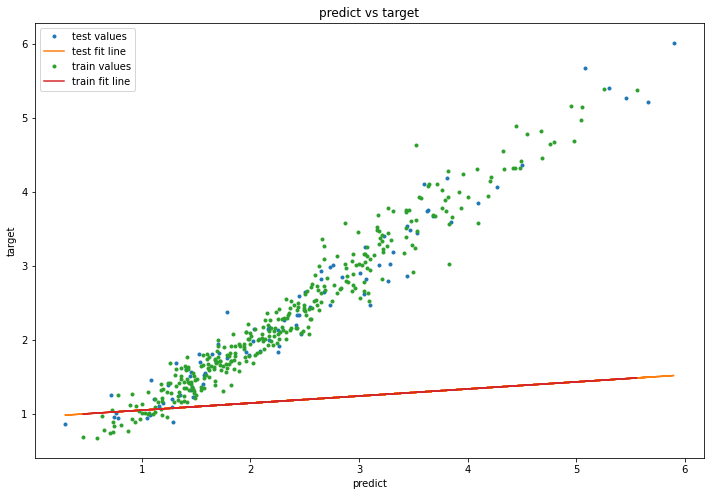

PCR


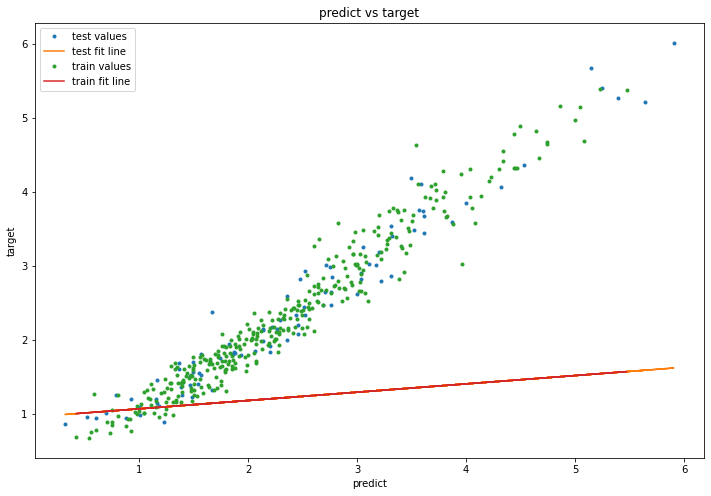

SVR


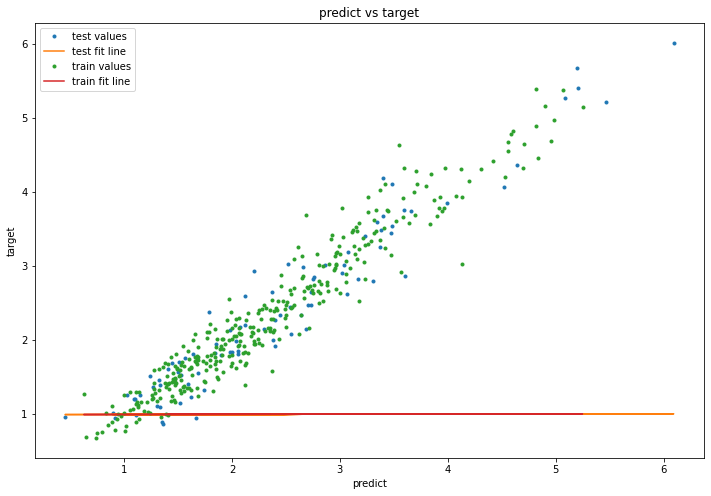

RFT


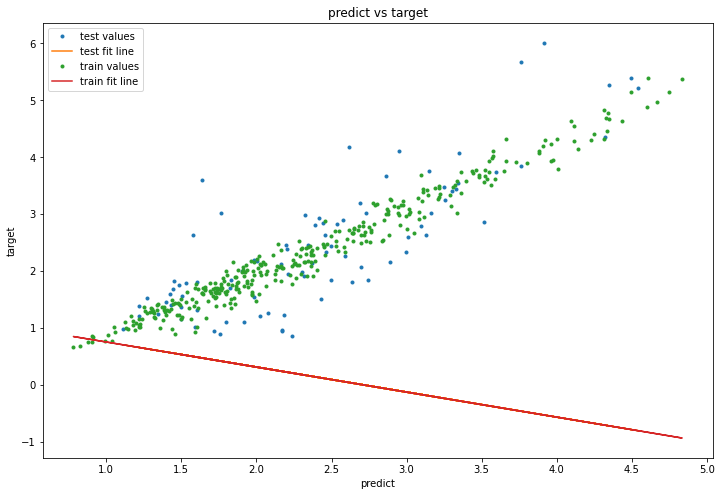

DT


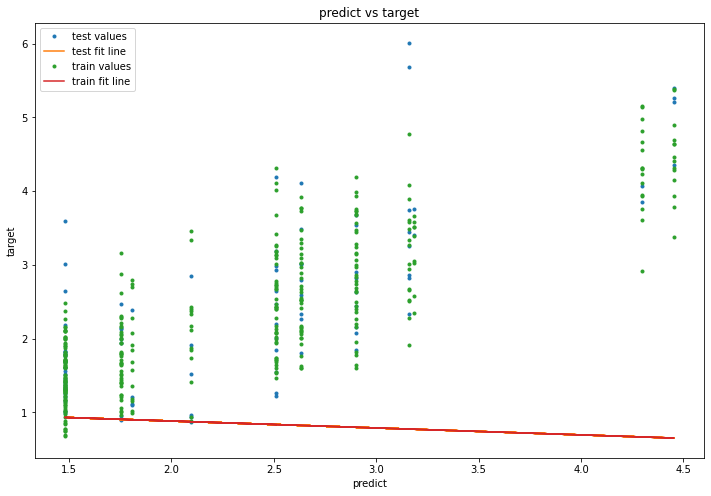

KNN


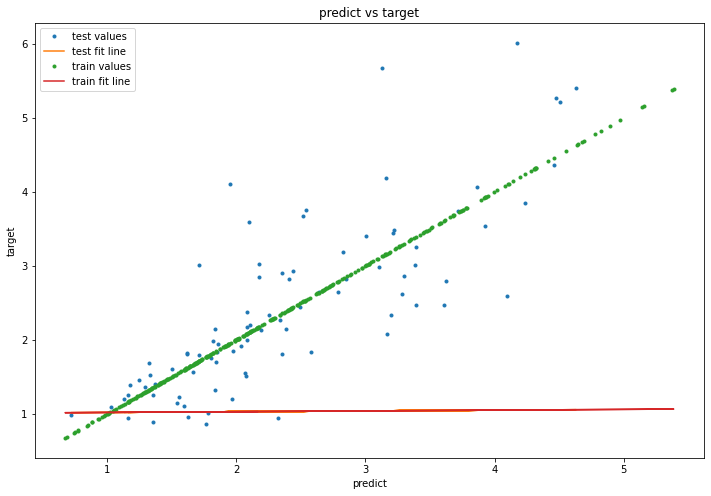

MLP


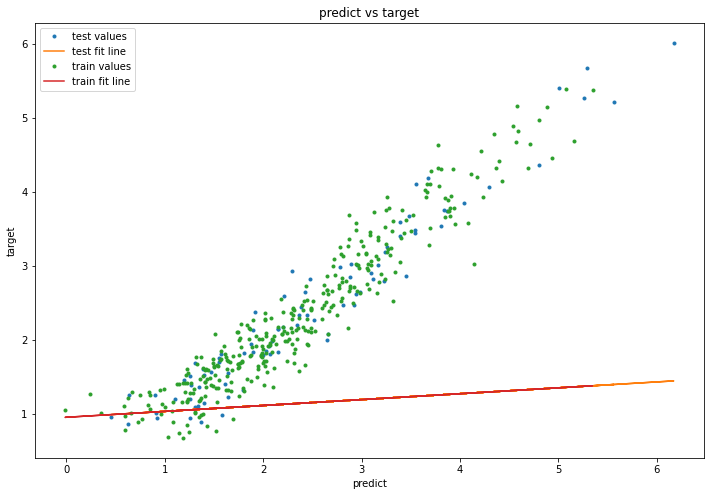

In [42]:
models=[pls,pcr,svr,rf,dt,knn,nnm]
modelsnames=["PLS","PCR","SVR","RFT","DT","KNN","MLP"]
for model,name in zip(models,modelsnames):
  prtest=model.predict(x_test).reshape(len(y_test),1)
  prtest=[i[0] for i in prtest]
  prtrain=model.predict(x_train).reshape(len(y_train),1)
  prtrain=[i[0] for i in prtrain]
  A, B = np.polyfit(prtest, y_test, 1)
  C, D = np.polyfit(prtrain, y_train, 1)
  drt_train=[A+(j*B) for j in prtrain]
  drt_test=[A+(j*B) for j in prtest]
  print(name)
  plt.plot(prtest,y_test,'.',label="test values")
  plt.plot(prtest, drt_test, '-',label="test fit line")
  plt.plot(prtrain,y_train,'.',label="train values")
  plt.plot(prtrain, drt_train, '-',label="train fit line")
  plt.legend(loc="upper left")
  plt.title("predict vs target")
  plt.xlabel("predict")
  plt.ylabel("target")
  plt.show()

PLS


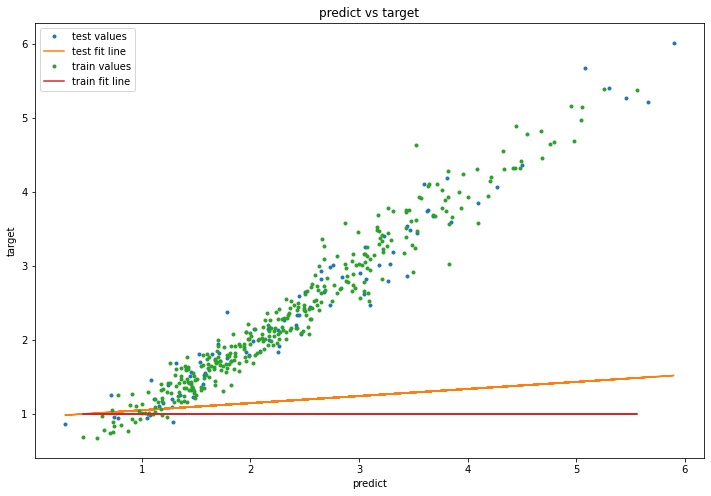

PCR


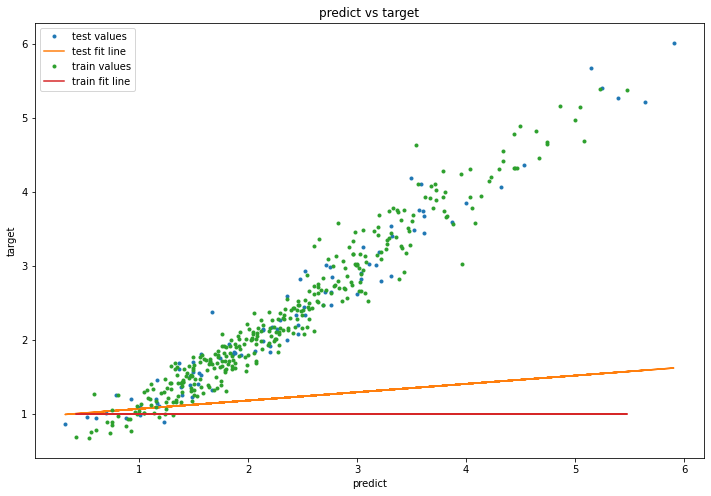

SVR


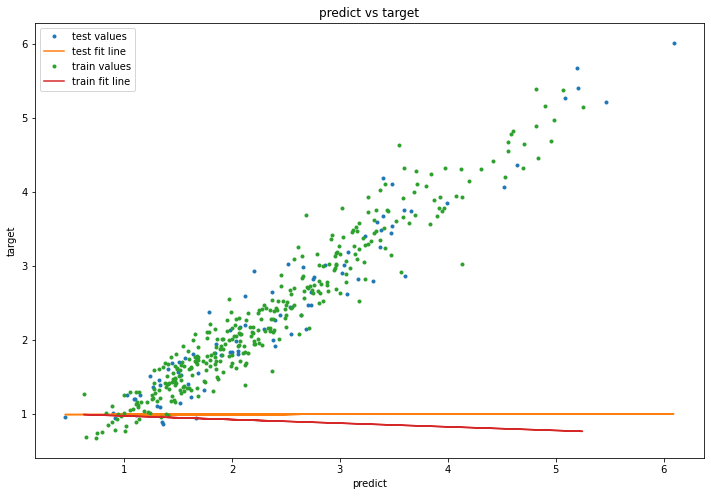

RFT


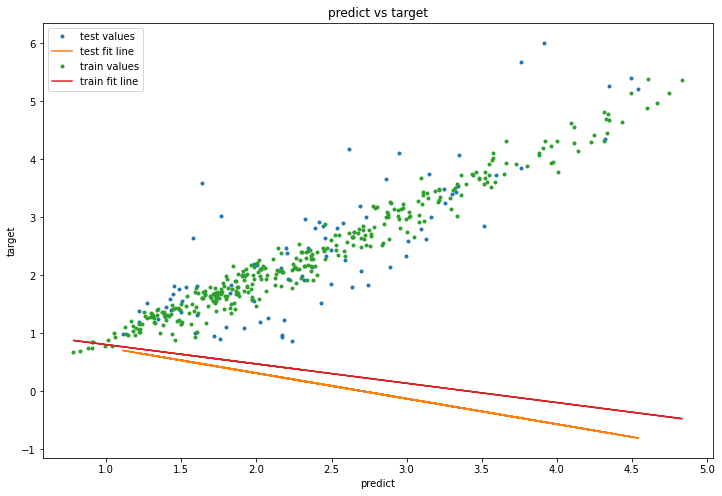

DT


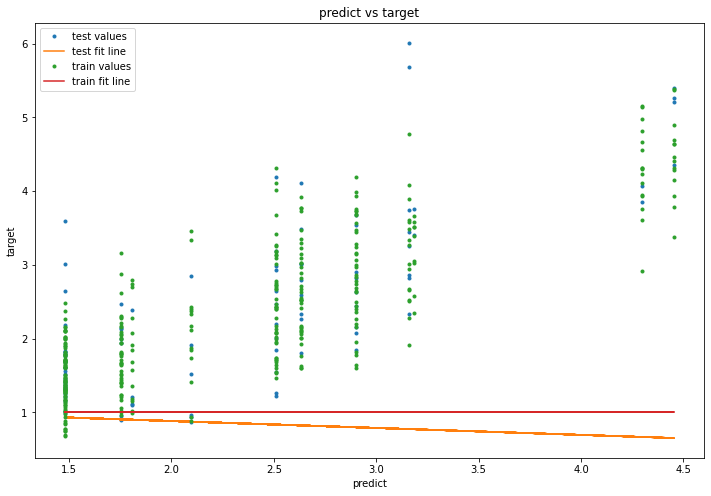

KNN


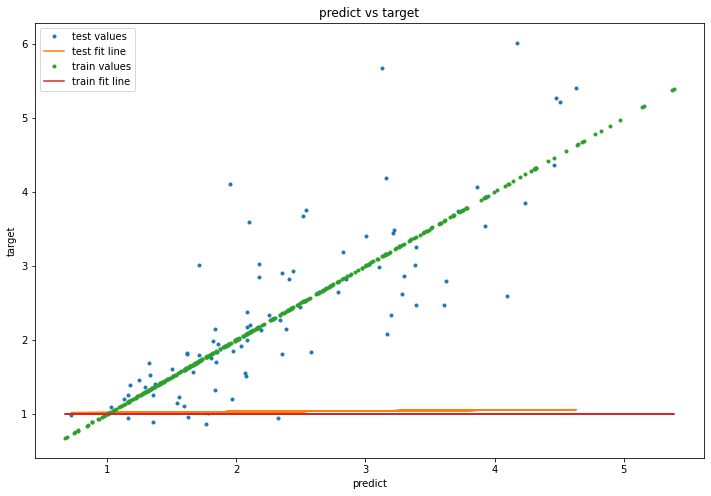

MLP


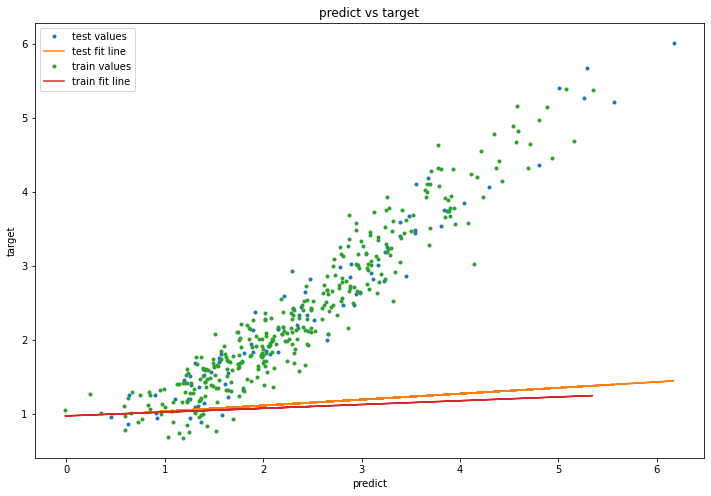

In [50]:
models=[pls,pcr,svr,rf,dt,knn,nnm]
modelsnames=["PLS","PCR","SVR","RFT","DT","KNN","MLP"]
for model,name in zip(models,modelsnames):
  prtest=model.predict(x_test).reshape(len(y_test),1)
  prtest=[i[0] for i in prtest]
  prtrain=model.predict(x_train).reshape(len(y_train),1)
  prtrain=[i[0] for i in prtrain]
  drt_test = sm.OLS(y_test,sm.add_constant(prtest)).fit()
  drt_train = sm.OLS(y_train,sm.add_constant(prtrain)).fit()
  val_train=[drt_train.params[1]+(j*drt_train.params[0]) for j in prtrain]
  val_test=[drt_test.params[1]+(j*drt_test.params[0]) for j in prtest]
  print(name)
  plt.plot(prtest,y_test,'.',label="test values")
  plt.plot(prtest, val_test, '-',label="test fit line")
  plt.plot(prtrain,y_train,'.',label="train values")
  plt.plot(prtrain, val_train, '-',label="train fit line")
  plt.legend(loc="upper left")
  plt.title("predict vs target")
  plt.xlabel("predict")
  plt.ylabel("target")
  plt.show()

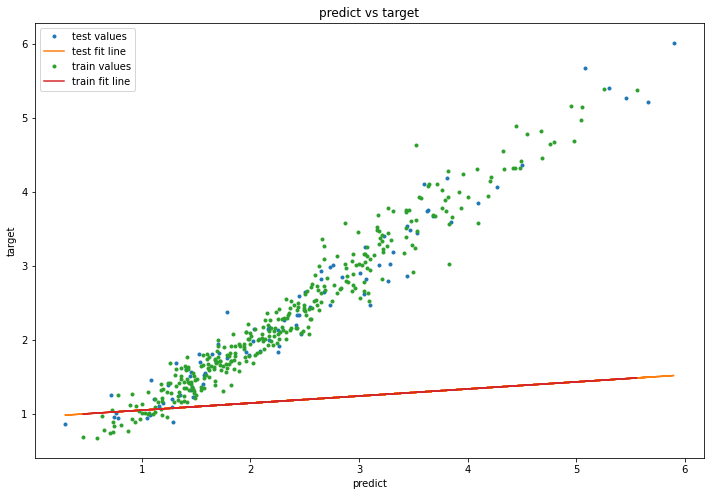

In [43]:
prtest=pls.predict(x_test).reshape(len(y_test),1)
prtest=[i[0] for i in prtest]
prtrain=pls.predict(x_train).reshape(len(y_train),1)
prtrain=[i[0] for i in prtrain]
A, B = np.polyfit(prtest, y_test, 1)
C, D = np.polyfit(prtrain, y_train, 1)
drt_train=[A+(j*B) for j in prtrain]
drt_test=[A+(j*B) for j in prtest]
plt.plot(prtest,y_test,'.',label="test values")
plt.plot(prtest, drt_test, '-',label="test fit line")
plt.plot(prtrain,y_train,'.',label="train values")
plt.plot(prtrain, drt_train, '-',label="train fit line")
plt.legend(loc="upper left")
plt.title("predict vs target")
plt.xlabel("predict")
plt.ylabel("target")
plt.show()

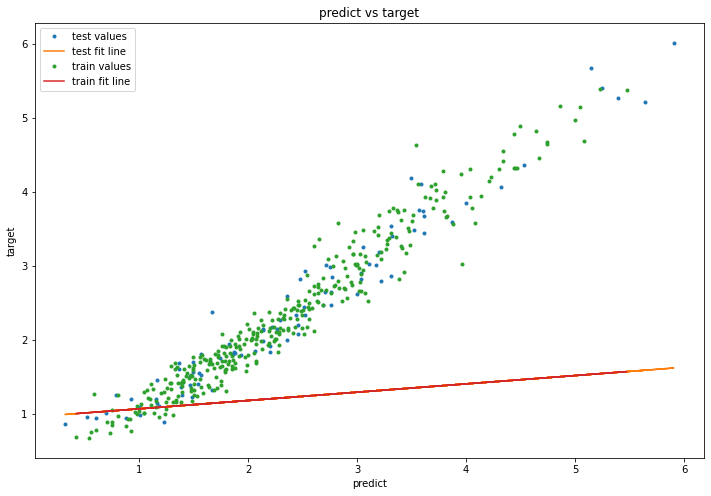

In [44]:
prtest=pcr.predict(x_test).reshape(len(y_test),1)
prtest=[i[0] for i in prtest]
prtrain=pcr.predict(x_train).reshape(len(y_train),1)
prtrain=[i[0] for i in prtrain]
A, B = np.polyfit(prtest, y_test, 1)
C, D = np.polyfit(prtrain, y_train, 1)
drt_train=[A+(j*B) for j in prtrain]
drt_test=[A+(j*B) for j in prtest]
plt.plot(prtest,y_test,'.',label="test values")
plt.plot(prtest, drt_test, '-',label="test fit line")
plt.plot(prtrain,y_train,'.',label="train values")
plt.plot(prtrain, drt_train, '-',label="train fit line")
plt.legend(loc="upper left")
plt.title("predict vs target")
plt.xlabel("predict")
plt.ylabel("target")
plt.show()

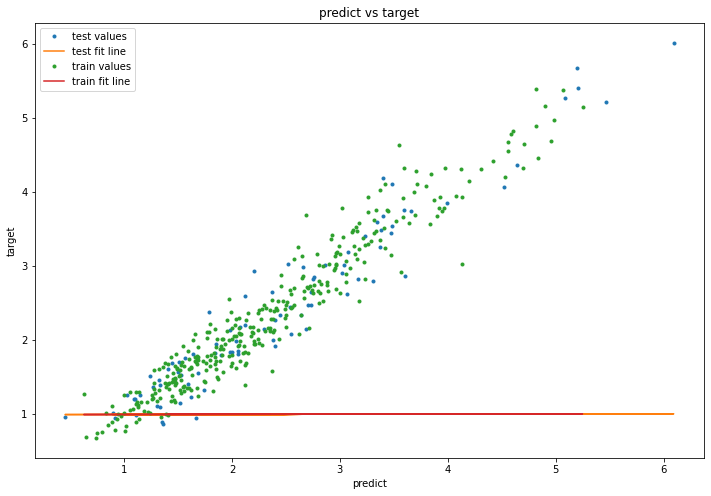

In [45]:
prtest=svr.predict(x_test).reshape(len(y_test),1)
prtest=[i[0] for i in prtest]
prtrain=svr.predict(x_train).reshape(len(y_train),1)
prtrain=[i[0] for i in prtrain]
A, B = np.polyfit(prtest, y_test, 1)
C, D = np.polyfit(prtrain, y_train, 1)
drt_train=[A+(j*B) for j in prtrain]
drt_test=[A+(j*B) for j in prtest]
plt.plot(prtest,y_test,'.',label="test values")
plt.plot(prtest, drt_test, '-',label="test fit line")
plt.plot(prtrain,y_train,'.',label="train values")
plt.plot(prtrain, drt_train, '-',label="train fit line")
plt.legend(loc="upper left")
plt.title("predict vs target")
plt.xlabel("predict")
plt.ylabel("target")
plt.show()

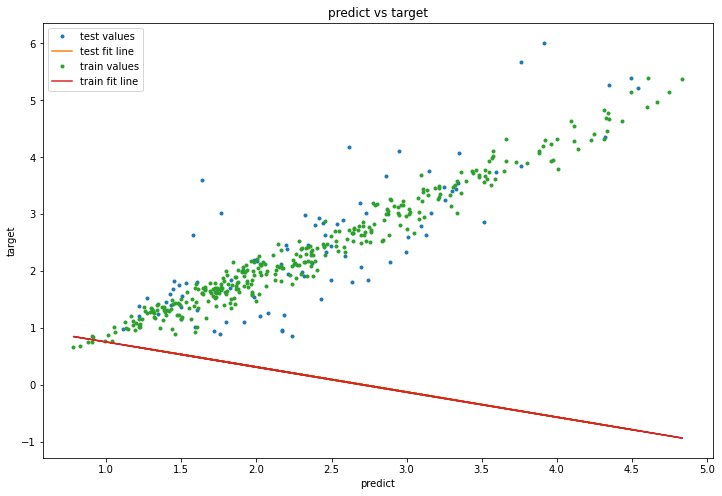

In [46]:
prtest=rf.predict(x_test).reshape(len(y_test),1)
prtest=[i[0] for i in prtest]
prtrain=rf.predict(x_train).reshape(len(y_train),1)
prtrain=[i[0] for i in prtrain]
A, B = np.polyfit(prtest, y_test, 1)
C, D = np.polyfit(prtrain, y_train, 1)
drt_train=[A+(j*B) for j in prtrain]
drt_test=[A+(j*B) for j in prtest]
plt.plot(prtest,y_test,'.',label="test values")
plt.plot(prtest, drt_test, '-',label="test fit line")
plt.plot(prtrain,y_train,'.',label="train values")
plt.plot(prtrain, drt_train, '-',label="train fit line")
plt.legend(loc="upper left")
plt.title("predict vs target")
plt.xlabel("predict")
plt.ylabel("target")
plt.show()

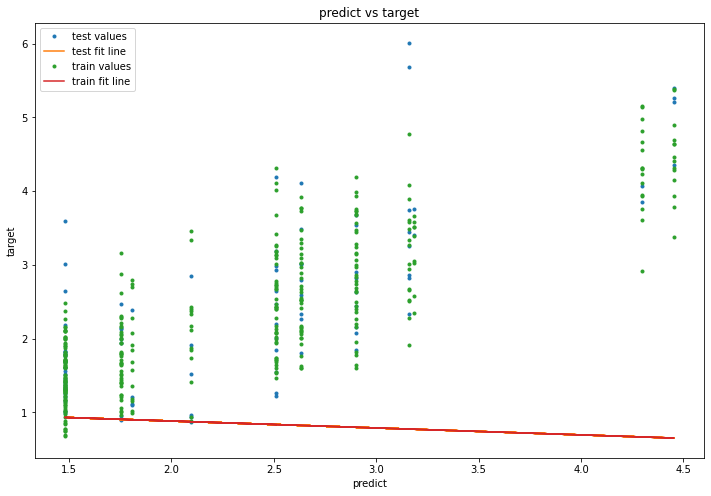

In [47]:
prtest=dt.predict(x_test).reshape(len(y_test),1)
prtest=[i[0] for i in prtest]
prtrain=dt.predict(x_train).reshape(len(y_train),1)
prtrain=[i[0] for i in prtrain]
A, B = np.polyfit(prtest, y_test, 1)
C, D = np.polyfit(prtrain, y_train, 1)
drt_train=[A+(j*B) for j in prtrain]
drt_test=[A+(j*B) for j in prtest]
plt.plot(prtest,y_test,'.',label="test values")
plt.plot(prtest, drt_test, '-',label="test fit line")
plt.plot(prtrain,y_train,'.',label="train values")
plt.plot(prtrain, drt_train, '-',label="train fit line")
plt.legend(loc="upper left")
plt.title("predict vs target")
plt.xlabel("predict")
plt.ylabel("target")
plt.show()

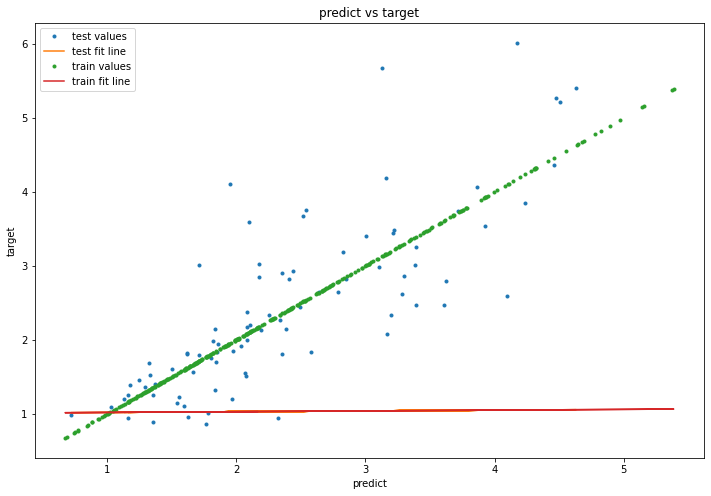

In [48]:
prtest=knn.predict(x_test).reshape(len(y_test),1)
prtest=[i[0] for i in prtest]
prtrain=knn.predict(x_train).reshape(len(y_train),1)
prtrain=[i[0] for i in prtrain]
A, B = np.polyfit(prtest, y_test, 1)
C, D = np.polyfit(prtrain, y_train, 1)
drt_train=[A+(j*B) for j in prtrain]
drt_test=[A+(j*B) for j in prtest]
plt.plot(prtest,y_test,'.',label="test values")
plt.plot(prtest, drt_test, '-',label="test fit line")
plt.plot(prtrain,y_train,'.',label="train values")
plt.plot(prtrain, drt_train, '-',label="train fit line")
plt.legend(loc="upper left")
plt.title("predict vs target")
plt.xlabel("predict")
plt.ylabel("target")
plt.show()

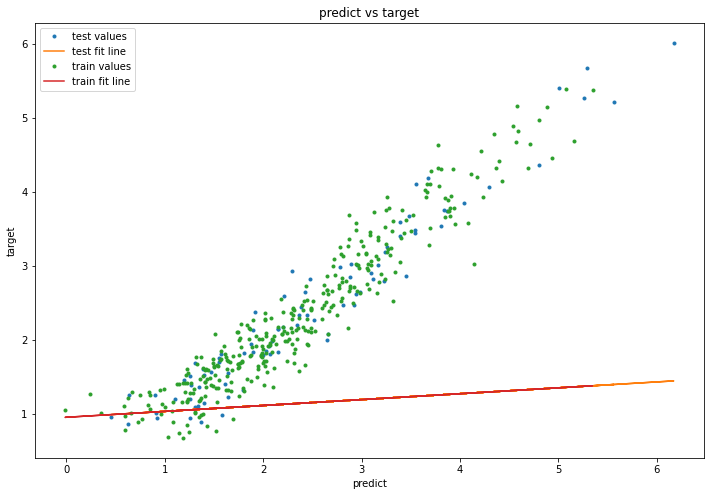

In [49]:
prtest=nnm.predict(x_test).reshape(len(y_test),1)
prtest=[i[0] for i in prtest]
prtrain=nnm.predict(x_train).reshape(len(y_train),1)
prtrain=[i[0] for i in prtrain]
A, B = np.polyfit(prtest, y_test, 1)
C, D = np.polyfit(prtrain, y_train, 1)
drt_train=[A+(j*B) for j in prtrain]
drt_test=[A+(j*B) for j in prtest]
plt.plot(prtest,y_test,'.',label="test values")
plt.plot(prtest, drt_test, '-',label="test fit line")
plt.plot(prtrain,y_train,'.',label="train values")
plt.plot(prtrain, drt_train, '-',label="train fit line")
plt.legend(loc="upper left")
plt.title("predict vs target")
plt.xlabel("predict")
plt.ylabel("target")
plt.show()